# Pre-Training a GPT Model from Scratch

This notebook walks through the complete process of **pre-training** a GPT-style language model. Pre-training is the foundational step where the model learns general language patterns from a large corpus of text.

## What is Pre-Training?

Pre-training teaches a model to predict the next token in a sequence. Given text like:

```
"The cat sat on the" → predict "mat"
```

Through millions of these predictions, the model learns:
- Grammar and syntax
- Word relationships and semantics  
- Facts and knowledge from the training data
- Reasoning patterns

## What We'll Cover

| Part | Topic |
|------|-------|
| 1 | **Model Architecture** - Build all GPT components (attention, feed-forward, transformer blocks) |
| 2 | **Text Generation** - See what an untrained model produces |
| 3 | **Loss Function** - Understand cross-entropy loss for next-token prediction |
| 4 | **Data Preparation** - Create training batches from raw text |
| 5 | **Training Loop** - Put it all together to train the model |
| 6 | **Decoding Strategies** - Temperature and Top-k sampling |
| 7 | **Saving Models** - Persist and load trained weights |
| 8 | **Loading GPT-2** - Use pre-trained weights from OpenAI |

## Why This Matters

Pre-training is **expensive** (GPT-3 cost ~$4.6M to train!) but creates a foundation that can be fine-tuned for many tasks. Understanding this process helps you:
- Debug training issues
- Make informed architecture decisions
- Understand model capabilities and limitations

---

## Install Dependencies

First, let's install the required packages:
- **torch**: PyTorch deep learning framework
- **tiktoken**: OpenAI's fast BPE tokenizer
- **transformers**: Hugging Face library (for comparison/utilities)

In [1]:
!pip install torch tiktoken transformers

## Setup: Detecting Hardware Acceleration

Modern deep learning benefits enormously from **hardware acceleration**. This function automatically detects the best available device:

| Device | Speed | Availability |
|--------|-------|--------------|
| **TPU** | Fastest | Google Colab Pro, Cloud TPU |
| **CUDA GPU** | Very Fast | NVIDIA graphics cards |
| **Apple MPS** | Fast | Apple Silicon Macs (M1/M2/M3) |
| **CPU** | Slowest | Always available |

The function checks in order of preference and returns the best available option. For this notebook:
- **GPU/TPU**: Training takes ~5-10 minutes
- **CPU**: Training takes ~30-60 minutes (but still works!)

In [2]:
# ============================================================
# Device Detection: CPU, GPU (CUDA), or TPU
# ============================================================

import torch

def get_device():
    """Detect and return the best available device."""
    
    # Check for TPU (Google Colab / Cloud TPU)
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        device_name = "TPU"
        print(f"✓ TPU detected!")
        return device, device_name
    except ImportError:
        pass
    
    # Check for CUDA GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name(0)
        print(f"✓ GPU detected: {device_name}")
        print(f"  - CUDA Version: {torch.version.cuda}")
        print(f"  - GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        return device, device_name
    
    # Check for Apple Silicon MPS
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        device_name = "Apple Silicon (MPS)"
        print(f"✓ Apple Silicon detected: {device_name}")
        return device, device_name
    
    # Fallback to CPU
    device = torch.device("cpu")
    device_name = "CPU"
    print(f"⚠ No GPU/TPU detected. Using CPU.")
    print(f"  - Training will be slower on CPU")
    return device, device_name

# Detect device
device, device_name = get_device()
print(f"\n→ Using device: {device}")

✓ GPU detected: NVIDIA A100-SXM4-40GB
  - CUDA Version: 12.6
  - GPU Memory: 42.47 GB

→ Using device: cuda


---

# Part 1: Building the Model Architecture

First, we need to assemble all the building blocks of our GPT model. We've covered these in previous notebooks, so here we'll import/define them and focus on how they work together.

## Multi-Head Attention

The **heart of the transformer**. Multi-head attention allows the model to:
- Look at different positions in the sequence simultaneously
- Learn different types of relationships (syntactic, semantic, etc.) via multiple "heads"
- Use **causal masking** to prevent looking at future tokens (crucial for language modeling!)

### How Multi-Head Attention Works:

```
Input: [batch, seq_len, d_model]
         │
         ├──→ Q = input @ W_query ──┐
         ├──→ K = input @ W_key   ──┼──→ Split into num_heads
         └──→ V = input @ W_value ──┘
                                    │
                    ┌───────────────┴───────────────┐
                    │     For each head:            │
                    │  1. attention = Q @ K.T       │
                    │  2. mask future positions     │
                    │  3. scale by √d_k             │
                    │  4. softmax → weights         │
                    │  5. output = weights @ V      │
                    └───────────────┬───────────────┘
                                    │
                            Concatenate all heads
                                    │
                            Output projection
                                    │
Output: [batch, seq_len, d_model]
```

### Key Parameters:
- `d_in`: Input dimension (embedding size)
- `d_out`: Output dimension (usually same as d_in)
- `num_heads`: Number of attention heads (d_out must be divisible by this)
- `context_length`: Maximum sequence length (for creating the causal mask)
- `dropout`: Regularization to prevent overfitting

In [3]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

## Layer Normalization

**Layer Normalization** stabilizes training by normalizing activations across the feature dimension.

### Why We Need It:

During training, the distribution of layer inputs can shift dramatically (called "internal covariate shift"). This makes training unstable and slow. Layer normalization fixes this by:

1. **Normalizing** each sample independently across features
2. **Scaling and shifting** with learnable parameters (so the model can undo normalization if needed)

### The Math:

```
For each token position:
    mean = average of all features
    var  = variance of all features
    
    normalized = (x - mean) / √(var + ε)
    output = scale * normalized + shift
```

### Why Layer Norm (not Batch Norm)?

| Batch Norm | Layer Norm |
|------------|------------|
| Normalizes across batch | Normalizes across features |
| Depends on batch size | Independent of batch size |
| Different behavior train/eval | Same behavior always |
| Bad for sequences | Great for sequences |

**GPT uses Layer Norm** because it works independently for each token, regardless of batch size or sequence length.

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## GELU Activation Function

**GELU** (Gaussian Error Linear Unit) is the activation function used in GPT and most modern transformers.

### Why Not ReLU?

ReLU is simple (`max(0, x)`) but has a problem: **dead neurons**. Once a neuron outputs 0, it may never recover during training.

### How GELU Works:

GELU is a **smooth approximation** that:
- Allows small negative values through (unlike ReLU which blocks all negatives)
- Is differentiable everywhere (unlike ReLU's sharp corner at 0)
- Acts like a "soft gate" based on the input's value

```
GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
```

### Why GELU is Better for Transformers:
- Smoother gradients → more stable training
- No dead neurons → better gradient flow
- Empirically works better for NLP tasks

In [5]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

## Feed-Forward Network (FFN)

The **Feed-Forward Network** is the "thinking" part of each transformer block. While attention figures out *what to look at*, the FFN processes *what to do with that information*.

### Architecture:

```
Input [batch, seq, 768]
        │
        ▼
┌───────────────────┐
│  Linear (768→3072)│  ← Expand to 4x size
└─────────┬─────────┘
          │
          ▼
┌───────────────────┐
│      GELU         │  ← Non-linearity
└─────────┬─────────┘
          │
          ▼
┌───────────────────┐
│  Linear (3072→768)│  ← Project back down
└─────────┬─────────┘
          │
          ▼
Output [batch, seq, 768]
```

### Why 4x Expansion?

The FFN temporarily expands the dimension by **4x** (768 → 3072). This gives the network more "room to think":

1. **More parameters** = more capacity to learn complex patterns
2. **Bottleneck design** = forces compression of information
3. **Empirically effective** = this ratio works well in practice

### Key Insight:

The FFN processes each token position **independently**. Unlike attention (which mixes information across positions), the FFN applies the same transformation to each token separately. This is why it's also called a "position-wise" feed-forward network.

In [6]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

## Transformer Block

The **Transformer Block** combines attention and feed-forward layers with **residual connections** and **layer normalization**. This is the repeating unit that gets stacked to create deep models.

### Architecture (Pre-Norm variant used in GPT-2/3):

```
        Input
          │
          ├─────────────────────┐
          │                     │ (residual/skip connection)
          ▼                     │
    ┌───────────┐               │
    │ LayerNorm │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
    ┌───────────┐               │
    │ Attention │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
    ┌───────────┐               │
    │  Dropout  │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
        (+)←────────────────────┘
          │
          ├─────────────────────┐
          │                     │ (residual/skip connection)
          ▼                     │
    ┌───────────┐               │
    │ LayerNorm │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
    ┌───────────┐               │
    │    FFN    │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
    ┌───────────┐               │
    │  Dropout  │               │
    └─────┬─────┘               │
          │                     │
          ▼                     │
        (+)←────────────────────┘
          │
        Output
```

### Why Residual Connections?

Residual (skip) connections are **critical** for training deep networks:

1. **Gradient flow**: Gradients can flow directly through skip connections, avoiding vanishing gradients
2. **Identity mapping**: The network can easily learn to "do nothing" if that's optimal
3. **Incremental learning**: Each layer learns a "delta" on top of existing representations

### Pre-Norm vs Post-Norm

GPT-2/3 use **Pre-Norm** (normalize before attention/FFN), which:
- Is more stable during training
- Allows for larger learning rates
- Enables training very deep models without warmup tricks

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

## GPT Configuration

Before building the model, we define its **hyperparameters**. These control the model's size and capacity.

### GPT-2 124M Configuration:

| Parameter | Value | Meaning |
|-----------|-------|---------|
| `vocab_size` | 50,257 | Number of unique tokens (BPE vocabulary) |
| `context_length` | 256 | Maximum sequence length (reduced from 1024 for speed) |
| `emb_dim` | 768 | Size of token embeddings |
| `n_heads` | 12 | Number of attention heads |
| `n_layers` | 12 | Number of transformer blocks |
| `drop_rate` | 0.1 | Dropout probability (10%) |
| `qkv_bias` | False | No bias in Q, K, V projections |

### Scaling Laws:

The model's capacity roughly scales with:
- **Width** (`emb_dim`): More features per token
- **Depth** (`n_layers`): More processing steps
- **Heads** (`n_heads`): More parallel attention patterns

GPT-2 sizes:
- **124M**: 12 layers, 768 dim, 12 heads (what we're using)
- **355M**: 24 layers, 1024 dim, 16 heads
- **774M**: 36 layers, 1280 dim, 20 heads
- **1.5B**: 48 layers, 1600 dim, 25 heads

In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,
    "qkv_bias": False
}

## The Complete GPT Model

Now we assemble all components into the full **GPTModel** class.

### Architecture Overview:

```
Token IDs [batch, seq_len]
          │
          ▼
┌─────────────────────┐
│  Token Embedding    │  Look up vectors for each token
│  [vocab → emb_dim]  │
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│ Position Embedding  │  Add position information
│ [seq_len → emb_dim] │
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│     Dropout         │  Regularization
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│  Transformer Block  │ ─┐
└──────────┬──────────┘  │
           │             │
           ▼             │ × 12 layers
┌─────────────────────┐  │
│  Transformer Block  │  │
└──────────┬──────────┘  │
           │             │
          ...           ─┘
           │
           ▼
┌─────────────────────┐
│    Final LayerNorm  │
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│    Output Head      │  Project to vocabulary size
│ [emb_dim → vocab]   │
└──────────┬──────────┘
           │
           ▼
    Logits [batch, seq_len, vocab_size]
```

### Key Points:

1. **Token + Position Embeddings**: The model needs both *what* token and *where* it is
2. **Stacked Transformer Blocks**: 12 identical blocks, each refining the representations
3. **Output Head**: Maps final representations back to vocabulary probabilities
4. **No bias in output**: `bias=False` in the final Linear layer (GPT-2 convention)

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Instantiate the Model

Let's create our GPT model and examine its structure.

### What Happens Here:

1. **Set random seed**: Ensures reproducible weight initialization
2. **Create model**: Instantiates all layers with random weights
3. **Set to eval mode**: Disables dropout (important for consistent outputs during testing)

### Model Size:

With our configuration, the model has approximately **124 million parameters**:
- Token embeddings: 50,257 × 768 = ~38.6M
- Position embeddings: 256 × 768 = ~0.2M  
- Each transformer block: ~7M parameters
- 12 blocks: ~84M
- Output head: 768 × 50,257 = ~38.6M (but shares weights with token embeddings in original GPT-2)

**Note**: Our implementation doesn't share weights between token embeddings and output head, so we have slightly more parameters.

In [10]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

---

# Part 2: Text Generation (Before Training)

Before training, let's see what our randomly-initialized model produces. Spoiler: it will be **complete gibberish**!

## Text Generation Process

The model generates text **one token at a time** using this loop:

```
1. Input: "Every effort moves you"
2. Model predicts probability distribution over ALL 50,257 tokens
3. Select the most likely token (argmax) or sample from distribution
4. Append new token to input
5. Repeat steps 2-4 for desired length
```

### Helper Functions:

- **`text_to_token_ids`**: Converts text → token IDs using GPT-2's BPE tokenizer
- **`token_ids_to_text`**: Converts token IDs → text
- **`generate_text_simple`**: The generation loop (greedy decoding with argmax)

### Why the Output is Garbage:

Our model has **random weights**. It hasn't learned:
- What words mean
- Grammar rules
- Which tokens typically follow others

The output will be essentially random tokens. This demonstrates why **pre-training is essential**!

In [11]:
import tiktoken

def generate_text_simple(model, idx,
                         max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


---

# Part 3: Understanding the Loss Function

Now we dive into the **most important concept for training**: the loss function.

## What is Loss?

**Loss** measures how wrong our model's predictions are. For language models:
- Lower loss = better predictions
- Higher loss = worse predictions

## Cross-Entropy Loss for Language Modeling

For next-token prediction, we use **cross-entropy loss**:

```
Loss = -log(probability of correct token)
```

### Intuition:

If the model predicts:
- Correct token with 90% probability → Loss = -log(0.9) = 0.105 (low, good!)
- Correct token with 1% probability → Loss = -log(0.01) = 4.6 (high, bad!)
- Correct token with 0.01% probability → Loss = -log(0.0001) = 9.2 (very high, terrible!)

## Setting Up the Example

We'll use two short sequences to understand how loss is calculated:

```
Batch 1: "every effort moves" → target: "effort moves you"
Batch 2: "I really like"      → target: "really like chocolate"
```

Each input token should predict the **next** token in the sequence.

In [12]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

### Create Input Tokens

These are the **token IDs** for our input sequences. The tokenizer converts words to numbers:
- `16833` = "every"
- `3626` = " effort" 
- `6100` = " moves"
- `40` = "I"
- `1107` = " really"
- `588` = " like"

In [13]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

### Create Target Tokens

The targets are simply the inputs **shifted by one position**. This is the essence of language modeling:

```
Input:  [every]  [effort] [moves]
Target: [effort] [moves]  [you]
         ↑        ↑        ↑
      predict   predict  predict
```

Each position learns to predict the **next** token.

In [14]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


### Get Model Predictions

Run the inputs through the model to get **logits** (raw scores before softmax).

The output shape is `[batch_size, seq_len, vocab_size]` = `[2, 3, 50257]`:
- 2 sequences in the batch
- 3 tokens per sequence
- 50,257 scores (one for each possible next token)

In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


### What Would the Model Predict?

Let's see which tokens the model would actually generate (using argmax to pick the highest probability token).

**Remember**: The model has random weights, so these predictions will be nonsense!

In [16]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


### Compare Predictions vs Targets

Let's decode both the targets (what we want) and predictions (what the model says).

As expected, the predictions are **completely wrong** - random tokens that don't make sense!

In [17]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


### Extract Probabilities for Target Tokens

Now let's see **how much probability** the model assigned to the correct tokens.

We use fancy indexing to extract just the probabilities for our target tokens:
- `probas[0, [0,1,2], targets[0]]` = probabilities at positions 0,1,2 for the target token IDs

**Expected**: Very low probabilities (around 1/50,257 ≈ 0.00002) since the model is random.

In [18]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


### Convert to Log Probabilities

We take the **logarithm** of probabilities because:

1. **Numerical stability**: Very small probabilities (like 0.00001) become manageable numbers
2. **Easier math**: Products become sums (important for sequences)
3. **Convention**: Cross-entropy loss uses log probabilities

```
prob = 0.00007  →  log(prob) = -9.5
prob = 0.00001  →  log(prob) = -11.5
```

**Note**: More negative = lower probability = worse prediction!

In [19]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


### Average Log Probability

We average the log probabilities across all tokens to get a single number representing overall model performance.

This average is **negative** because log probabilities are always ≤ 0.

In [20]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


### Negative Average Log Probability = Cross-Entropy Loss!

We negate the average to get a **positive** loss value:

```
Cross-Entropy Loss = -mean(log(probability of correct tokens))
```

This is exactly what `torch.nn.functional.cross_entropy` computes!

**Goal of training**: Minimize this loss → Maximize probability of correct tokens.

In [21]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


## Using PyTorch's Cross-Entropy Function

The manual calculation above was educational, but in practice we use PyTorch's optimized `cross_entropy` function.

### The Challenge: Shape Mismatch

PyTorch's `cross_entropy` expects:
- `input`: `[N, C]` where N = samples, C = classes
- `target`: `[N]` 

But our shapes are:
- `logits`: `[batch, seq_len, vocab]` = `[2, 3, 50257]`
- `targets`: `[batch, seq_len]` = `[2, 3]`

**Solution**: Flatten the batch and sequence dimensions!

In [22]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


### Flatten for Cross-Entropy

```
Before flattening:
  logits:  [2, 3, 50257]  →  2 batches × 3 positions × 50257 vocab
  targets: [2, 3]         →  2 batches × 3 positions

After flattening:
  logits:  [6, 50257]     →  6 total predictions × 50257 vocab
  targets: [6]            →  6 total targets
```

Now each of the 6 predictions is treated as an independent classification problem!

In [23]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Compute Cross-Entropy Loss

PyTorch's `cross_entropy`:
1. Applies softmax to logits internally
2. Takes log
3. Selects values at target indices
4. Averages and negates

The result matches our manual calculation exactly (10.7940)!

In [24]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


## Perplexity: A More Interpretable Metric

**Perplexity** is cross-entropy loss converted to a more intuitive scale:

```
Perplexity = e^(cross_entropy_loss)
```

### Intuition:

Perplexity ≈ "How many tokens is the model confused between?"

| Perplexity | Meaning |
|------------|---------|
| 1 | Perfect! Model is 100% confident and correct |
| 10 | Model is "choosing" between ~10 equally likely tokens |
| 100 | Model is "choosing" between ~100 equally likely tokens |
| 50,000 | Nearly random guessing (vocab size is 50,257) |

### For Our Random Model:

Perplexity ≈ 48,726 means the model is essentially guessing randomly among all tokens. After training, we'd expect perplexity in the range of 10-50 for a good model.

In [25]:
import tiktoken
import requests
import os
from torch.utils.data import Dataset, DataLoader

url = "https://www.gutenberg.org/cache/epub/84/pg84.txt"
filename = "pg84.txt"

# Download the file if it doesn't exist
if not os.path.exists(filename):
    print(f"Downloading '{filename}'...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Successfully downloaded '{filename}'")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print(f"'{filename}' already exists, skipping download.")

# Load the text
with open(filename, "r", encoding="utf-8") as f:
    text_data = f.read()

Successfully downloaded 'pg84.txt'


---

# Part 4: Preparing Training Data

Now we need real text data to train on. We'll use **"Frankenstein" by Mary Shelley** from Project Gutenberg - it's free, classic literature, and a good size for demonstration.

## The Data Pipeline:

```
Raw Text File
     │
     ▼
┌─────────────┐
│  Tokenize   │  Convert text → token IDs using BPE
└──────┬──────┘
       │
       ▼
┌─────────────┐
│   Create    │  Sliding window to create input-target pairs
│   Dataset   │
└──────┬──────┘
       │
       ▼
┌─────────────┐
│ DataLoader  │  Batch, shuffle, and iterate efficiently
└──────┬──────┘
       │
       ▼
  Training Loop
```

## Download the Training Text

We'll download Frankenstein (~440KB of text, ~106K tokens) - small enough to train quickly but large enough to see real learning.

In [26]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 438807
Tokens: 106361


### Check Dataset Size

Let's see how much data we have:
- **Characters**: Raw text length
- **Tokens**: After BPE tokenization (typically 3-4 characters per token for English)

~106K tokens is small by modern standards (GPT-3 trained on 300B tokens!) but sufficient for demonstration.

In [27]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

### Train/Validation Split

We split the data into:
- **90% Training**: Model learns from this
- **10% Validation**: Used to check if model is overfitting

**Important**: We split by position, not randomly. This ensures:
1. No data leakage between train and validation
2. Validation tests the model on "future" text it hasn't seen

In [28]:

class GPTDatasetV1(Dataset):
    """Creates input-target pairs using sliding window for next-token prediction."""
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    """Create a DataLoader with GPT-2 BPE tokenization."""
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

## GPT Dataset: Creating Input-Target Pairs

The `GPTDatasetV1` class creates training examples using a **sliding window**:

```
Text: "The monster approached the village slowly"
      ─────────────────────────────────────────

With max_length=4, stride=4:

Example 1:
  Input:  [The, monster, approached, the]
  Target: [monster, approached, the, village]
  
Example 2:
  Input:  [village, slowly, ...]
  Target: [slowly, ..., ...]
```

### Key Parameters:

| Parameter | Effect |
|-----------|--------|
| `max_length` | Sequence length (context window size) |
| `stride` | How far to move between examples |

### Stride Strategies:

- **stride = max_length**: No overlap, each token used once per epoch
- **stride < max_length**: Overlapping windows, more examples but redundant data
- **stride = 1**: Maximum examples, but highly redundant

We use `stride = max_length` (256) for efficiency.

In [29]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

### Create Data Loaders

**DataLoaders** handle:
- **Batching**: Group examples together for parallel processing
- **Shuffling**: Randomize order each epoch (training only)
- **Dropping incomplete batches**: Ensures consistent batch sizes

Settings:
- `batch_size=2`: Small for demonstration (real training uses 32-512)
- `shuffle=True` for training, `False` for validation
- `drop_last=True` for training to avoid small final batches

In [30]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

### Verify Data Loader Output

Let's check that our data loaders produce the expected shapes:
- Each batch should have shape `[batch_size, seq_length]` = `[2, 256]`
- Both inputs (x) and targets (y) have the same shape

The training loader should have more batches than the validation loader (90% vs 10% of data).

In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

---

# Part 5: Training Infrastructure

Before the main training loop, we need helper functions to calculate loss efficiently.

## Batch Loss Function

`calc_loss_batch` computes the cross-entropy loss for a single batch:

1. Move data to the right device (CPU or GPU)
2. Run forward pass to get logits
3. Flatten and compute cross-entropy loss

This is the same loss calculation we did manually earlier, but packaged as a reusable function.

In [32]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

## Dataset Loss Function

`calc_loss_loader` computes the average loss over an entire data loader:

1. Iterate through batches
2. Accumulate losses
3. Return the average

### Optional `num_batches` Parameter:

For large datasets, computing loss on ALL batches is slow. The `num_batches` parameter lets you estimate the loss using only a subset of data - useful for quick progress checks during training.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Device Selection

Deep learning benefits enormously from **GPU acceleration**:

| Device | Training Speed |
|--------|---------------|
| CPU | 1x (baseline) |
| GPU (CUDA) | 10-100x faster |
| TPU | Even faster (specialized) |

PyTorch automatically detects if a CUDA-capable GPU is available. If not, it falls back to CPU.

**Note**: Training on CPU is fine for learning, but real models require GPUs!

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.986330868726109
Validation loss: 10.984492619832357


## Baseline Loss (Before Training)

Let's measure the loss on both training and validation sets **before any training**.

### What to Expect:

For a randomly initialized model with vocabulary size 50,257:
- Expected loss ≈ log(50,257) ≈ **10.82**
- This is the loss you'd get from random guessing

If our initial loss is close to 10.82, it confirms the model is starting from random weights (as expected).

### Why Check Both Train and Val Loss?

- **Training loss**: How well does the model fit the training data?
- **Validation loss**: How well does the model generalize to unseen data?

If training loss goes down but validation loss goes up → **overfitting**!

## Helper Functions for Training

Before we start training, we need two essential helper functions:

### 1. `generate_and_print_sample`

This function generates sample text during training to **visually monitor progress**:

```python
1. Set model to eval mode (disables dropout)
2. Encode the starting text to token IDs
3. Generate new tokens using our simple generation function
4. Decode and print the result
5. Set model back to training mode
```

**Why generate during training?**
- Loss numbers alone don't tell you if the model is generating coherent text
- Seeing generated text helps you catch problems early
- It's satisfying to watch the model improve!

### 2. `evaluate_model`

This function calculates loss on both training and validation sets:

```python
1. Set model to eval mode
2. Calculate average loss on training data
3. Calculate average loss on validation data
4. Set model back to training mode
5. Return both losses
```

We use `torch.no_grad()` during evaluation to:
- Save memory (no gradients stored)
- Speed up computation (no backward pass needed)

In [35]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [36]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

## The Training Loop

This is where the magic happens! `train_model_simple` implements the core **training loop** that teaches the model to predict next tokens.

### The Training Process (Each Epoch):

```
For each epoch:
    For each batch in training data:
        1. Zero gradients           ← Reset from previous step
        2. Forward pass             ← Compute predictions
        3. Calculate loss           ← Compare to targets
        4. Backward pass            ← Compute gradients
        5. Update weights           ← Apply gradients via optimizer
        
    Every eval_freq steps:
        - Evaluate on train & val sets
        - Log the losses
        
    At end of epoch:
        - Generate sample text
```

### Key Concepts:

| Step | What Happens | Why |
|------|--------------|-----|
| `optimizer.zero_grad()` | Reset gradients to zero | Gradients accumulate by default |
| `loss.backward()` | Compute gradients via backprop | Determines how to update weights |
| `optimizer.step()` | Update weights using gradients | The actual learning! |

### Tracking Progress:

The function returns three lists:
- `train_losses`: Training loss over time
- `val_losses`: Validation loss over time  
- `tokens_seen`: Cumulative tokens processed

These help us visualize learning curves and detect overfitting.

In [37]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

## Start Training!

Now we instantiate everything and begin training:

### Components:

1. **Model**: Fresh GPTModel with random weights
2. **Optimizer**: AdamW - the go-to optimizer for transformers
3. **Hyperparameters**:
   - `lr=0.0004`: Learning rate (how big each update step is)
   - `weight_decay=0.1`: L2 regularization to prevent overfitting
   - `num_epochs=10`: How many times to see the full dataset

### AdamW vs Adam:

AdamW **decouples weight decay** from the gradient update:
- Regular Adam: applies weight decay to gradients (incorrect L2 regularization)
- AdamW: applies weight decay directly to weights (correct L2 regularization)

This is especially important for transformers!

### What to Watch:

During training, you'll see:
```
Ep 1 (Step 000005): Train loss 10.234, Val loss 10.456
...
Ep 10 (Step 000415): Train loss 0.678, Val loss 1.234
```

And sample generations that improve from gibberish to (somewhat) coherent text!

In [38]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.768, Val loss 9.840
Ep 1 (Step 000005): Train loss 8.269, Val loss 8.392
Ep 1 (Step 000010): Train loss 7.305, Val loss 7.642
Ep 1 (Step 000015): Train loss 7.135, Val loss 7.364
Ep 1 (Step 000020): Train loss 7.101, Val loss 7.295
Ep 1 (Step 000025): Train loss 7.094, Val loss 7.192
Ep 1 (Step 000030): Train loss 7.057, Val loss 7.095
Ep 1 (Step 000035): Train loss 6.852, Val loss 7.002
Ep 1 (Step 000040): Train loss 6.882, Val loss 6.933
Ep 1 (Step 000045): Train loss 6.731, Val loss 6.876
Ep 1 (Step 000050): Train loss 6.725, Val loss 6.805
Ep 1 (Step 000055): Train loss 6.396, Val loss 6.726
Ep 1 (Step 000060): Train loss 6.423, Val loss 6.695
Ep 1 (Step 000065): Train loss 6.452, Val loss 6.631
Ep 1 (Step 000070): Train loss 6.230, Val loss 6.604
Ep 1 (Step 000075): Train loss 6.344, Val loss 6.568
Ep 1 (Step 000080): Train loss 6.386, Val loss 6.488
Ep 1 (Step 000085): Train loss 6.237, Val loss 6.443
Ep 1 (Step 000090): Train loss 6.163, Val loss

## Visualizing Training Progress

Plotting the loss curves is essential for understanding how training went.

### What the Plot Shows:

- **X-axis (bottom)**: Epochs (complete passes through training data)
- **X-axis (top)**: Tokens seen (cumulative count)
- **Y-axis**: Cross-entropy loss
- **Blue line**: Training loss
- **Dashed line**: Validation loss

### How to Read the Curves:

| Pattern | Meaning | Action |
|---------|---------|--------|
| Both decreasing together | Healthy training | Continue! |
| Train ↓, Val flat | Starting to overfit | Consider stopping |
| Train ↓↓, Val ↑ | Overfitting | Stop training, add regularization |
| Both flat | Learning stalled | Increase learning rate |
| Both erratic | LR too high | Decrease learning rate |

### Key Insights:

1. **Gap between curves**: Some gap is normal; large gap = overfitting
2. **Diminishing returns**: Improvement slows as loss decreases
3. **Validation is truth**: Training loss can always go down; validation shows real generalization

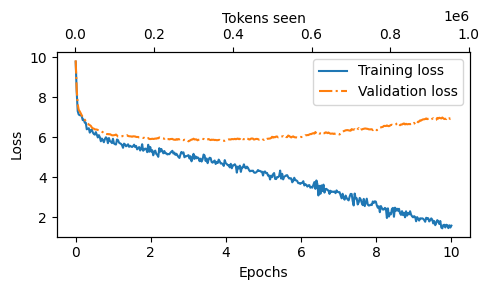

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Switching to CPU for Inference

After training, we:
1. Move the model to CPU (if it was on GPU)
2. Set to evaluation mode with `model.eval()`

### Why Move to CPU?

- **Memory**: Frees up GPU memory for other tasks
- **Portability**: CPU inference works everywhere
- **Saving**: Easier to save/load models on CPU

### Why `model.eval()`?

Switches the model from training mode to evaluation mode:
- **Dropout**: Disabled (uses all neurons)
- **BatchNorm**: Uses running statistics (not applicable here, but good habit)
- Ensures consistent, reproducible outputs

In [40]:

model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Test the Trained Model

Let's see what our trained model generates!

### Before Training (Random Weights):
```
"Every effort moves you rendezvous 
Ede diameterEde diameter Ede..."
```

### After Training:
The model should now generate more coherent, Frankenstein-like text. It won't be perfect (we only trained on one book for a short time), but it should:
- Use real English words
- Follow basic grammar
- Sound somewhat like the training text

### Limitations:

Our model is:
- **Small**: 124M parameters (GPT-4 has ~1.8T)
- **Undertrained**: Only saw ~1M tokens (GPT-3 saw 300B)
- **Limited data**: Only one book (real LLMs train on internet-scale data)

But it demonstrates the core concepts!

In [41]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you
that a
and from the edges of a more cheerfulies. The



and the earth had been discovered


---

# Part 6: Decoding Strategies - Temperature and Top-k Sampling

So far we've used **greedy decoding**: always pick the highest probability token. This is deterministic but can be boring and repetitive.

## Better Decoding Strategies

Real language models use **sampling** with various controls:

1. **Temperature**: Controls randomness/creativity
2. **Top-k Sampling**: Only sample from the k most likely tokens
3. **Top-p (Nucleus) Sampling**: Sample from tokens covering p% probability mass

## Setting Up a Simple Example

Let's use a tiny vocabulary to understand these concepts clearly:

```
vocab = {closer, every, effort, forward, inches, moves, pizza, toward, you}
```

We'll explore how different decoding strategies affect which token gets selected.

In [42]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

### Example Logits

These are example **logits** (raw model outputs before softmax) for predicting the next token after "Every effort moves you":

```
forward: 6.75  ← Highest logit
toward:  6.28  ← Second highest
closer:  4.51
you:     1.79
inches:  1.63
every:   0.89
moves:  -1.62
pizza:  -1.89
effort: -1.90  ← Lowest logit
```

**Note**: "forward" and "toward" make sense as next words ("Every effort moves you forward/toward..."), while "pizza" doesn't!

In [43]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

### Greedy Decoding (Argmax)

With greedy decoding, we:
1. Convert logits to probabilities via softmax
2. Pick the token with highest probability (argmax)

This **always** picks "forward" because it has the highest logit/probability.

### Pros and Cons:

| Pros | Cons |
|------|------|
| Deterministic | Repetitive output |
| Fast | Misses creative alternatives |
| Predictable | Can get stuck in loops |

In [44]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


### Random Sampling (Multinomial)

Instead of always picking the best, we **sample randomly** according to the probability distribution:

- "forward" (p=0.45): Most likely to be picked, but not always
- "toward" (p=0.30): Second most likely
- "closer" (p=0.05): Occasionally picked
- etc.

`torch.multinomial(probas, num_samples=1)` samples one token according to these probabilities.

### Why Sample?

- **Diversity**: Different runs produce different outputs
- **Creativity**: Explores less obvious continuations
- **Natural**: Real language has variation

In [45]:
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


### Visualizing Sampling Distribution

Let's sample 1000 tokens to see the actual distribution.

With pure sampling, the frequency of each token should roughly match its probability:
- "forward" appears ~450 times (45%)
- "toward" appears ~300 times (30%)
- Rare tokens appear occasionally

This shows sampling respects the probability distribution while adding variety.

In [46]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
             for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


## Temperature Scaling

**Temperature** controls how "peaked" or "flat" the probability distribution is.

### The Formula:

```python
scaled_logits = logits / temperature
probas = softmax(scaled_logits)
```

### Effect of Temperature:

| Temperature | Effect | Use Case |
|-------------|--------|----------|
| T < 1.0 | Sharper distribution (more confident) | Factual, focused output |
| T = 1.0 | Original distribution | Balanced |
| T > 1.0 | Flatter distribution (more random) | Creative writing |
| T → 0 | Approaches greedy (argmax) | Most predictable |
| T → ∞ | Approaches uniform random | Maximum chaos |

### Intuition:

- **Low temperature** (T=0.1): "Be very confident, stick to high-probability tokens"
- **High temperature** (T=5.0): "Be adventurous, consider unlikely tokens too"

In [47]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

### Visualizing Temperature Effects

This plot shows how temperature changes the probability distribution:

- **T=1.0** (baseline): Original distribution from the model
- **T=0.1** (cold): Almost all probability on "forward" (very peaked)
- **T=5.0** (hot): Much more uniform distribution across all tokens

### Practical Usage:

```
Chat/Q&A → T=0.3-0.7 (focused, accurate)
Creative writing → T=0.8-1.2 (balanced creativity)
Brainstorming → T=1.2-1.5 (more diverse ideas)
```

**Warning**: Temperature > 2.0 often produces incoherent text!

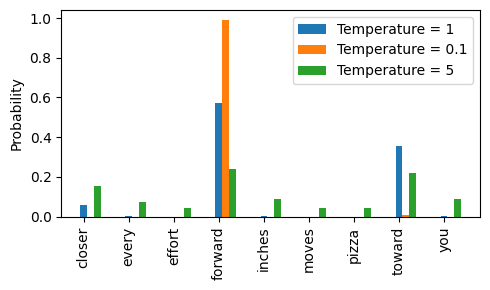

In [48]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Top-k Sampling

**Top-k sampling** restricts sampling to only the k most probable tokens.

### How It Works:

1. Get logits for all vocabulary tokens
2. Find the k highest logits
3. Set all other logits to -infinity (zero probability after softmax)
4. Sample from the remaining k tokens

### Example with k=3:

```
Original:  [forward: 6.75, toward: 6.28, closer: 4.51, ...]
After top-3: [forward: 6.75, toward: 6.28, closer: 4.51, 
              others: -inf, -inf, -inf, ...]
```

Now we can only sample from {forward, toward, closer}!

In [49]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


### Implementing Top-k: Masking Low-Probability Tokens

`torch.where` conditionally replaces values:
- Tokens with logit < min(top-k logits) → set to -infinity
- Tokens in top-k → keep original logit

After this masking:
```
forward:  6.75  ← kept
toward:   6.28  ← kept
closer:   4.51  ← kept (this is the k-th highest)
you:     -inf   ← masked out
inches:  -inf   ← masked out
...
```

The -infinity values become 0 probability after softmax.

In [50]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


### Final Top-k Probabilities

After applying softmax to the masked logits:

```
forward: ~50%
toward:  ~35%
closer:  ~15%
others:   0%
```

Now sampling can only pick from these three sensible options!

### Why Top-k?

| Benefit | Explanation |
|---------|-------------|
| Prevents nonsense | Low-probability tokens (like "pizza") are excluded |
| Maintains diversity | Still samples, doesn't always pick the best |
| Controllable | k=1 is greedy, k=vocab_size is pure sampling |

### Choosing k:

- `k=1`: Greedy decoding
- `k=10-50`: Common for most tasks
- `k=100+`: Very diverse, might include odd tokens

In [51]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Advanced Generation Function

Now we combine everything into a production-ready generation function with:

1. **Temperature scaling**: Control creativity/randomness
2. **Top-k filtering**: Exclude low-probability tokens
3. **Early stopping**: Stop generation at end-of-sequence token

### Function Parameters:

| Parameter | Purpose |
|-----------|---------|
| `model` | The trained GPT model |
| `idx` | Starting token IDs |
| `max_new_tokens` | Maximum tokens to generate |
| `context_size` | Maximum context window |
| `temperature` | Creativity control (0.0 = greedy) |
| `top_k` | Number of top tokens to sample from |
| `eos_id` | End-of-sequence token to stop at |

### Generation Logic:

```
For each new token:
    1. Get logits from model
    2. Apply top-k filtering (if enabled)
    3. Apply temperature scaling (if temp > 0)
    4. Sample or argmax depending on temperature
    5. Check for EOS token
    6. Append new token
```

In [52]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

### Testing the Advanced Generator

Let's generate with:
- `top_k=25`: Only consider top 25 tokens
- `temperature=1.4`: Slightly creative/random

Compare this to our earlier greedy generation:
- **Greedy**: Always the same output, might be repetitive
- **With sampling**: Different each run, more natural variety

### Experimenting with Settings:

Try different combinations:
```python
# Focused, deterministic
generate(..., temperature=0.0, top_k=None)

# Balanced
generate(..., temperature=0.7, top_k=50)

# Very creative
generate(..., temperature=1.5, top_k=100)
```

In [53]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you not one an tale only a lively form? You
I shall accompany



---

# Part 7: Saving and Loading Models

Training is expensive! We need to save our trained models to:
- Resume training later
- Deploy for inference
- Share with others

## Method 1: Save Just the Weights

`torch.save(model.state_dict(), "model.pth")` saves:
- All learned parameters (weights and biases)
- Does NOT save: model architecture, optimizer state, training progress

### File Format:

- `.pth` or `.pt`: PyTorch convention (actually pickle format)
- Contains a dictionary mapping parameter names to tensors

### When to Use:

- Final model deployment
- Sharing trained weights
- When you don't need to resume training

In [58]:
torch.save(model.state_dict(), "model.pth")

### Loading Saved Weights

To load saved weights:

1. **Create the model architecture** (must match saved weights exactly!)
2. **Load the state dict** from file
3. **Set to eval mode** for inference

```python
model = GPTModel(CONFIG)           # 1. Same architecture
model.load_state_dict(torch.load("model.pth"))  # 2. Load weights
model.eval()                        # 3. Evaluation mode
```

### Important Notes:

- Architecture must be identical (same config)
- `map_location` helps load GPU-trained models on CPU
- Always call `model.eval()` before inference!

In [59]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Method 2: Save Model + Optimizer (Checkpoint)

For **resuming training**, we need to save more:
- Model weights
- Optimizer state (momentum, learning rate schedules, etc.)
- Optionally: epoch number, loss history, random state

### Why Save Optimizer State?

Optimizers like AdamW maintain:
- **Momentum terms**: Running averages of gradients
- **Adaptive learning rates**: Per-parameter learning rate scaling

Without these, resumed training starts "cold" and may perform worse!

In [60]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

### Loading a Full Checkpoint

To resume training:

1. Load the checkpoint dictionary
2. Create fresh model and optimizer
3. Load state dicts into both
4. Set model to training mode

```python
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()  # Ready to continue training!
```

### Best Practices:

- Save checkpoints periodically during training
- Include epoch/step number in filename
- Keep the best model based on validation loss

In [61]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

---

# Part 8: Loading Pre-trained GPT-2 Weights

Training a model from scratch is educational, but for real applications we often start with **pre-trained weights**. Let's load the official GPT-2 weights from OpenAI!

## Why Use Pre-trained Weights?

| Training from Scratch | Using Pre-trained |
|----------------------|-------------------|
| Random initialization | Trained on WebText |
| Need lots of data | Already knows language |
| Expensive ($$, time) | Free and instant |
| Custom architecture | Must match architecture |

## Installing Dependencies

We need TensorFlow to load GPT-2's original checkpoint format.

In [62]:
!pip install tensorflow>=2.15.0  tqdm>=4.66

### Download Weight Loading Script

We'll use a helper script that handles downloading GPT-2 weights from OpenAI's servers and converting them to a format we can use.

The script:
1. Downloads the GPT-2 checkpoint files
2. Loads TensorFlow weights
3. Converts to a Python dictionary format

In [63]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7fba45290590>)

### Download and Load GPT-2 Weights

This downloads the **124M parameter** GPT-2 model (~500MB):

```
models/gpt2/
├── checkpoint          # TF checkpoint metadata
├── encoder.json        # Vocabulary
├── hparams.json        # Model config
├── model.ckpt.data     # The actual weights
├── model.ckpt.index    # Weight index
└── vocab.bpe           # BPE merges
```

The function returns:
- `settings`: Model hyperparameters (dimensions, layers, etc.)
- `params`: Dictionary of all weight tensors

In [64]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 198kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.18MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 247kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:29<00:00, 5.56MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 11.7MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 908kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 616kiB/s] 


### Examine GPT-2 Configuration

Let's see what's in the loaded data:

**Settings** contain architecture hyperparameters:
```python
{
    "n_vocab": 50257,   # Vocabulary size
    "n_ctx": 1024,      # Context length
    "n_embd": 768,      # Embedding dimension
    "n_head": 12,       # Attention heads
    "n_layer": 12       # Transformer blocks
}
```

**Params** contain the actual weight tensors:
- `wte`: Token embeddings
- `wpe`: Position embeddings  
- `blocks`: List of transformer block weights
- `g`, `b`: Final layer norm

In [65]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


### Inspect Token Embeddings

The `wte` (word token embeddings) matrix has shape `[50257, 768]`:
- 50,257 tokens in the vocabulary
- 768-dimensional embedding for each token

These embeddings encode the **meaning** of each token, learned from billions of words of text!

In [66]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


### GPT-2 Model Sizes

GPT-2 comes in four sizes. Here are their configurations:

| Model | Parameters | Layers | Dim | Heads |
|-------|-----------|--------|-----|-------|
| Small | 124M | 12 | 768 | 12 |
| Medium | 355M | 24 | 1024 | 16 |
| Large | 774M | 36 | 1280 | 20 |
| XL | 1.5B | 48 | 1600 | 25 |

**Scaling pattern**: Deeper (more layers) AND wider (larger dimensions)

In [67]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

### Update Config for GPT-2

We need to update our model configuration to exactly match GPT-2's architecture.

Starting from our base config, we update:
- `emb_dim`: Embedding dimension (768 for small)
- `n_layers`: Number of transformer blocks (12 for small)
- `n_heads`: Number of attention heads (12 for small)

In [68]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

### Set Correct Context Length

GPT-2 was trained with a context length of **1024 tokens**, not 256 like our training runs.

This must match exactly because:
- Position embeddings have shape `[context_length, emb_dim]`
- The causal mask is created for this size

In [69]:
NEW_CONFIG.update({"context_length": 1024})

### Enable QKV Bias

GPT-2 uses **biases in the Q, K, V projections**:
```python
qkv_bias = True
```

Our implementation had `qkv_bias=False` for training, but we need `True` to load GPT-2 weights.

**Note**: This is a common difference between model variants. Always check!

In [70]:
NEW_CONFIG.update({"qkv_bias": True})

### Create Compatible Model

Now we create a fresh `GPTModel` with the updated configuration.

This model has:
- Correct architecture matching GPT-2
- Random weights (we'll replace these next)
- 1024 context length
- QKV biases enabled

In [71]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Weight Assignment Helper

The `assign` function safely copies weights:

1. **Shape check**: Ensures source and target shapes match exactly
2. **Convert to Parameter**: Wraps the tensor as a learnable parameter
3. **Error handling**: Fails loudly if shapes don't match

This catches bugs early - mismatched shapes usually mean architecture differences!

In [72]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

## Loading All GPT-2 Weights

`load_weights_into_gpt` is the main function that copies all weights from the GPT-2 checkpoint into our model.

### Weight Mapping:

| GPT-2 Name | Our Name | What It Is |
|------------|----------|-----------|
| `wpe` | `pos_emb.weight` | Position embeddings |
| `wte` | `tok_emb.weight` | Token embeddings |
| `blocks[i].attn.c_attn.w` | `W_query/key/value` | Attention projections |
| `blocks[i].attn.c_proj` | `out_proj` | Attention output |
| `blocks[i].mlp.c_fc` | `ff.layers[0]` | FFN first layer |
| `blocks[i].mlp.c_proj` | `ff.layers[2]` | FFN second layer |
| `blocks[i].ln_1` | `norm1` | First layer norm |
| `blocks[i].ln_2` | `norm2` | Second layer norm |

### Key Detail: Transposing Weights

GPT-2 stores weights in `[in, out]` format, but PyTorch Linear layers expect `[out, in]`. We transpose with `.T` to fix this.

### Weight Tying

Notice `out_head.weight = wte` - GPT-2 **ties** output and input embeddings, meaning the same weights are used for both token lookup and prediction!

In [73]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### Apply Weights to Model

Load all the weights and move the model to the appropriate device (GPU if available).

After this, our model contains the exact same weights as OpenAI's GPT-2!

In [74]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## Test Pre-trained GPT-2!

Now we can generate text using the pre-trained GPT-2 weights.

### The Difference:

**Our trained model** (on Frankenstein):
- Limited vocabulary of concepts
- Frankenstein-style writing
- ~1M tokens of training

**Pre-trained GPT-2**:
- Knows about everything on the internet (circa 2019)
- Diverse writing styles
- ~40GB of text (~8M web pages)

### Try Different Prompts:

```python
"The meaning of life is"
"In a shocking turn of events,"
"def fibonacci(n):"
```

GPT-2 can complete all of these sensibly because it learned from diverse internet text!

In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I
